In [1]:
import os
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

2023-01-29 06:13:51.651877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 06:14:08.229187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


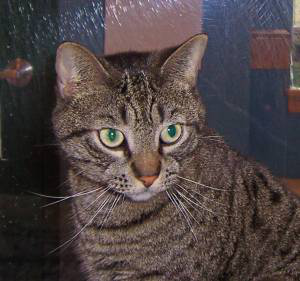

In [2]:
src_img = Image.open('data/train/cat/1.jpg')
display(src_img)

In [3]:
np.array(src_img).shape

(281, 300, 3)

In [4]:
# if flattened, it would result in this many features:
281 * 300 * 3

252900

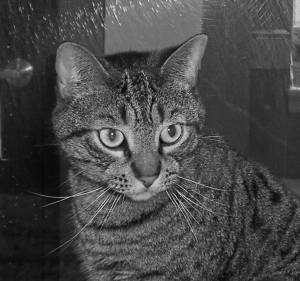

In [5]:
gray_img = ImageOps.grayscale(src_img)
display(gray_img)

In [6]:
np.array(gray_img).shape

(281, 300)

In [7]:
281 * 300

84300

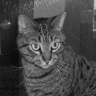

In [8]:
gray_resized_img = gray_img.resize(size=(96, 96))
display(gray_resized_img)

In [9]:
np.array(gray_resized_img).shape

(96, 96)

In [10]:
96 * 96

9216

# Flatten the image and store it as an array:

In [11]:
np.ravel(gray_resized_img)

array([42, 42, 51, ..., 68, 37, 36], dtype=uint8)

- The values aren't in an ideal range (0-255)
- Neural network model prefers 0-1 range
- Let's transform it:

In [12]:
img_final = np.ravel(gray_resized_img) / 255.0
img_final

array([0.16470588, 0.16470588, 0.2       , ..., 0.26666667, 0.14509804,
       0.14117647])

# Finally, let's implement all of this in a single function:

In [13]:
def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=(96, 96))
    img = np.ravel(img) / 255.0
    return img

In [14]:
tst_img = process_image(img_path='data/validation/dog/10012.jpg')
tst_img

array([0.24705882, 0.23921569, 0.29019608, ..., 0.19215686, 0.20784314,
       0.23921569])

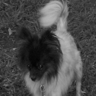

In [15]:
Image.fromarray(np.uint8(tst_img * 255).reshape((96, 96)))

# Process the entire dataset

In [16]:
def process_folder(folder: pathlib.PosixPath) -> pd.DataFrame:
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpg':
            # Two images failed for whatever reason, so let's just ignore them
            try:
                processed.append(process_image(img_path=str(img)))
            except Exception as _:
                continue
           
    # Convert to pd.DataFrame
    processed = pd.DataFrame(processed)
    # Add a class column - dog or a cat
    processed['class'] = folder.parts[-1]
    
    return processed

In [17]:
%%time
# SageMaker ml.r5.large instance

train_cat = process_folder(folder=pathlib.Path.cwd().joinpath('data/train/cat'))
train_dog = process_folder(folder=pathlib.Path.cwd().joinpath('data/train/dog'))

train_set = pd.concat([train_cat, train_dog], axis=0)

with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)

CPU times: user 2min 15s, sys: 7.01 s, total: 2min 22s
Wall time: 2min 39s


In [19]:
train_set.shape

(20031, 9217)

In [20]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.705882,0.701961,0.694118,0.674510,0.666667,0.662745,0.658824,0.662745,0.666667,0.666667,...,0.298039,0.298039,0.294118,0.294118,0.294118,0.278431,0.250980,0.329412,0.352941,cat
1,0.200000,0.196078,0.200000,0.188235,0.196078,0.196078,0.184314,0.196078,0.196078,0.184314,...,0.572549,0.525490,0.501961,0.529412,0.568627,0.517647,0.419608,0.427451,0.447059,cat
2,0.796078,0.776471,0.749020,0.772549,0.733333,0.729412,0.662745,0.670588,0.682353,0.694118,...,0.643137,0.615686,0.627451,0.611765,0.600000,0.600000,0.619608,0.588235,0.650980,cat
3,0.356863,0.392157,0.345098,0.439216,0.450980,0.419608,0.431373,0.439216,0.411765,0.396078,...,0.152941,0.137255,0.109804,0.101961,0.129412,0.109804,0.109804,0.121569,0.109804,cat
4,0.082353,0.082353,0.086275,0.082353,0.113725,0.227451,0.239216,0.239216,0.247059,0.243137,...,0.423529,0.407843,0.384314,0.380392,0.352941,0.333333,0.341176,0.317647,0.290196,cat


# Now for the test set:

In [21]:
%%time

# SageMaker ml.r5.large instance

test_cat = process_folder(folder=pathlib.Path.cwd().joinpath('data/test/cat'))
test_dog = process_folder(folder=pathlib.Path.cwd().joinpath('data/test/dog'))

test_set = pd.concat([test_cat, test_dog], axis=0)

with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

CPU times: user 14.7 s, sys: 611 ms, total: 15.3 s
Wall time: 17.8 s


In [22]:
test_set.shape

(2490, 9217)

# And finally for the validation set:

In [23]:
%%time

valid_cat = process_folder(folder=pathlib.Path.cwd().joinpath('data/validation/cat'))
valid_dog = process_folder(folder=pathlib.Path.cwd().joinpath('data/validation/dog'))

valid_set = pd.concat([valid_cat, valid_dog], axis=0)

with open('valid_set.pkl', 'wb') as f:
    pickle.dump(valid_set, f)

CPU times: user 14.6 s, sys: 638 ms, total: 15.3 s
Wall time: 17.2 s


In [24]:
valid_set.shape

(2477, 9217)

- Additional processing
- Datasets now contain images of cats first, followed by images of dogs
- We want to shuffle those datasets, so a neural network goes through the images in a random order:

In [26]:
train_set = shuffle(train_set).reset_index(drop=True)
valid_set = shuffle(valid_set).reset_index(drop=True)

train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.352941,0.156863,0.074510,0.133333,0.098039,0.176471,0.176471,0.168627,0.176471,0.200000,...,0.513725,0.454902,0.274510,0.227451,0.188235,0.317647,0.313725,0.235294,0.207843,cat
1,0.235294,0.247059,0.266667,0.258824,0.247059,0.247059,0.262745,0.250980,0.254902,0.250980,...,0.188235,0.180392,0.203922,0.156863,0.113725,0.062745,0.054902,0.047059,0.050980,dog
2,0.109804,0.113725,0.117647,0.121569,0.125490,0.121569,0.125490,0.129412,0.133333,0.133333,...,0.454902,0.443137,0.400000,0.376471,0.415686,0.419608,0.380392,0.345098,0.337255,cat
3,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,0.988235,...,0.533333,0.494118,0.447059,0.411765,0.376471,0.403922,0.482353,0.501961,0.423529,cat
4,0.549020,0.482353,0.501961,0.545098,0.670588,0.556863,0.439216,0.564706,0.580392,0.545098,...,0.321569,0.466667,0.513725,0.603922,0.670588,0.450980,0.454902,0.517647,0.635294,dog


Separate the features from the target:

In [28]:
X_train = train_set.drop('class', axis=1)
y_train = train_set['class']

X_valid = valid_set.drop('class', axis=1)
y_valid = valid_set['class']

X_test = test_set.drop('class', axis=1)
y_test = test_set['class']

We need to factorize the target variable
For example, if our classes are ['cat', 'dog'], the function will convert them to integers [0, 1]
Then, each instance is represented as follows:
Cat: [1, 0]
Dog: [0, 1]

In [29]:
y_train.factorize()

(array([0, 1, 0, ..., 0, 0, 0]), Index(['cat', 'dog'], dtype='object'))

In [30]:
y_train = tf.keras.utils.to_categorical(y_train.factorize()[0], num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid.factorize()[0], num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test.factorize()[0], num_classes=2)

In [31]:
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Training the model

In [32]:
%%time

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

2023-01-29 06:30:15.498940: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-29 06:30:15.499013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-89-67.ec2.internal): /proc/driver/nvidia/version does not exist
2023-01-29 06:30:15.501816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
157/157 [==============================] - 23s 125ms/step - loss: 0.9459 - accuracy: 0.5312 - val_loss: 0.6662 - val_accuracy: 0.5939
Epoch 2/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6729 - accuracy: 0.5816 - val_loss: 0.6578 - val_accuracy: 0.6161
Epoch 3/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6586 - accuracy: 0.6050 - val_loss: 0.6625 - val_accuracy: 0.5999
Epoch 4/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6577 - accuracy: 0.6091 - val_loss: 0.6536 - val_accuracy: 0.6052
Epoch 5/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6529 - accuracy: 0.6146 - val_loss: 0.6637 - val_accuracy: 0.5737
Epoch 6/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6492 - accuracy: 0.6183 - val_loss: 0.6483 - val_accuracy: 0.6225
Epoch 7/100
157/157 [==============================] - 19s 123ms/step - loss: 0.6462 - accuracy: 0.6232 - val_loss: 0.6450 -